[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/12YKHOXgPyXKLQV2Q2HYCceG13JMszqb-?usp=sharing)

Source: https://github.com/ezponda/intro_deep_learning/blob/main/class/Fundamentals/NN_Fundamentals.ipynb

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib.pyplot as plt
%matplotlib inline

keras.utils.set_random_seed(0)

# This will make TensorFlow ops as deterministic as possible, but it will
# affect the overall performance, so it's not enabled by default.
# `enable_op_determinism()` is introduced in TensorFlow 2.9.
tf.config.experimental.enable_op_determinism()

In [2]:

def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    h = 0.05
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[:,0], X[:,1], c=y.ravel(), cmap=plt.cm.Spectral)

def load_planar_dataset(m, sigma=0.2):
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*sigma # theta
        r = a*np.sin(4*t) + np.random.randn(N)*sigma # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j

    ## premuting ouput
    p = np.random.permutation(m)
    X = X[p,:]
    Y = Y[p,:]

    return X, Y.ravel()

def draw_neural_net(left, right, bottom, top, layer_sizes):
    '''
    From https://gist.github.com/craffel/2d727968c3aaebd10359#file-draw_neural_net-py
    Draw a neural network cartoon using matplotilb.

    :usage:
        >>> fig = plt.figure(figsize=(12, 12))
        >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])

    :parameters:
        - ax : matplotlib.axes.AxesSubplot
            The axes on which to plot the cartoon (get e.g. by plt.gca())
        - left : float
            The center of the leftmost node(s) will be placed here
        - right : float
            The center of the rightmost node(s) will be placed here
        - bottom : float
            The center of the bottommost node(s) will be placed here
        - top : float
            The center of the topmost node(s) will be placed here
        - layer_sizes : list of int
            List of layer sizes, including input and output dimensionality
    '''
    fig = plt.figure(figsize=(3, 3))
    ax = fig.gca()
    ax.axis('off')

    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)

## Dataset

We have a binary classification dataset. The target `y` has two possible values, {0,1} and the input vector `x` has two dimensions.

In [3]:
N = 5000
X, y = load_planar_dataset(N, 0.2)

Visualize the dataset using matplotlib. The data looks like a "flower" with some red (label y=0) and some blue (y=1) points. Your goal is to build a model to fit this data.

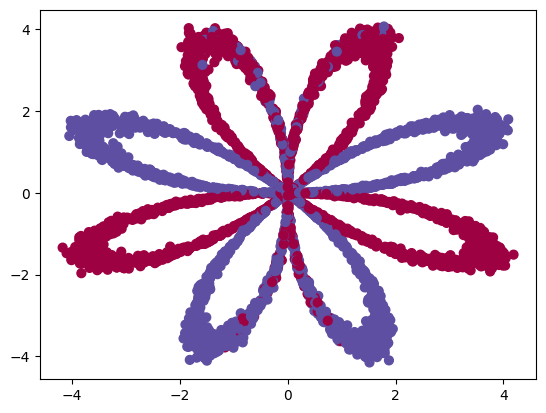

In [4]:
# Visualize the data:
plt.scatter(X[:,0], X[:,1], c=y.ravel(), s=40, cmap=plt.cm.Spectral);

In [5]:
# train test split
from sklearn.model_selection import train_test_split

(X_train, X_test, y_train, y_test) = train_test_split(
    X,
    y,
    test_size=0.2,
)

In [6]:
print('X shape:{0}, y shape:{1}'.format(X.shape, y.shape))
print('X_train shape:{0}, y_train shape:{1}'.format(X_train.shape,
                                                    y_train.shape))
print('X_test shape:{0}, y_test shape:{1}'.format(X_test.shape, y_test.shape))

X shape:(5000, 2), y shape:(5000,)
X_train shape:(4000, 2), y_train shape:(4000,)
X_test shape:(1000, 2), y_test shape:(1000,)


In [7]:
## X first example
X[0,:]

array([ 0.34000393, -0.30416122])

In [8]:
## Y firsts examples
y[:8]

array([0, 1, 1, 0, 0, 1, 1, 1], dtype=uint8)

## First NN in Keras

### Logistic regression

Fully connected layers are defined using the [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) class. We can specify the number of neurons as the first argument, and specify the activation function using the activation argument.

```python
tf.keras.layers.Dense(
    units, activation=None
)

```

- **units**: Number of neurons in the layer.
- **activation**: Activation function to use, default function is `linear`, you can also use `sigmoid` for sigmoid activation or [other alternatives](https://www.tensorflow.org/api_docs/python/tf/keras/activations)

For defining the input layer you can use `keras.Input(shape=(input_dimension,))` or define your input dimension in the first hidden layer.

```python
layers.Dense(4, activation="sigmoid", input_shape=(input_dimension,))

```

Build a network without hidden layer

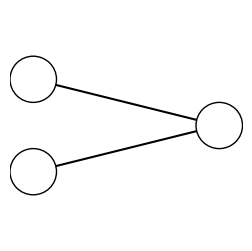

In [9]:
draw_neural_net(.1, .9, .1, .9, [2, 1])

In [10]:
model = keras.Sequential()
# The dimension of the input is 2 (planar data)
# we have only one output layer with 1 neuron
model.add(keras.layers.Dense(1, input_shape=(2, ), activation='sigmoid'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 3         
                                                                 
Total params: 3 (12.00 Byte)
Trainable params: 3 (12.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


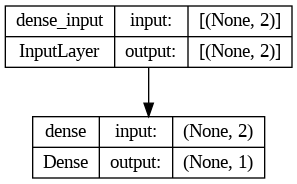

In [12]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

#### Compile
Now we need to specify the loss function, the metrics and the optimizer. It is done using compile function in Keras.

In [13]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

#### Training model
This is similar to a sklearn model.

In [14]:
model.fit(X_train, y_train, epochs=10,
          validation_split=0.2, batch_size=32)

Epoch 1/10
100/100 [==============================] - 1s 7ms/step - loss: 0.6786 - accuracy: 0.4750 - val_loss: 0.6850 - val_accuracy: 0.4812
Epoch 2/10
100/100 [==============================] - 0s 4ms/step - loss: 0.6686 - accuracy: 0.4641 - val_loss: 0.6746 - val_accuracy: 0.4762
Epoch 3/10
100/100 [==============================] - 0s 3ms/step - loss: 0.6625 - accuracy: 0.4666 - val_loss: 0.6693 - val_accuracy: 0.4750
Epoch 4/10
100/100 [==============================] - 0s 2ms/step - loss: 0.6596 - accuracy: 0.4694 - val_loss: 0.6665 - val_accuracy: 0.4737
Epoch 5/10
100/100 [==============================] - 0s 2ms/step - loss: 0.6584 - accuracy: 0.4675 - val_loss: 0.6650 - val_accuracy: 0.4750
Epoch 6/10
100/100 [==============================] - 0s 2ms/step - loss: 0.6578 - accuracy: 0.4728 - val_loss: 0.6644 - val_accuracy: 0.4787
Epoch 7/10
100/100 [==============================] - 0s 3ms/step - loss: 0.6577 - accuracy: 0.4737 - val_loss: 0.6640 - val_accuracy: 0.4775
Epoch 

#### Making predictions

In [15]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

Test Loss: 0.6636049151420593
Test Accuracy: 0.4650000035762787


In [16]:
y_pred = model.predict(X_test)
y_pred[:3], y_test[:3]

32/32 [==============================] - 0s 2ms/step


(array([[0.342457  ],
        [0.7245682 ],
        [0.61847997]], dtype=float32),
 array([0, 1, 0], dtype=uint8))

In [17]:
# clasification metrics
from sklearn.metrics import confusion_matrix, classification_report

y_pred_class = (y_pred > 0.5).astype('int32')

print(confusion_matrix(y_test, y_pred_class))
print(classification_report(y_test, y_pred_class))

[[213 308]
 [227 252]]
              precision    recall  f1-score   support

           0       0.48      0.41      0.44       521
           1       0.45      0.53      0.49       479

    accuracy                           0.47      1000
   macro avg       0.47      0.47      0.46      1000
weighted avg       0.47      0.47      0.46      1000



1269/1269 [==============================] - 2s 1ms/step


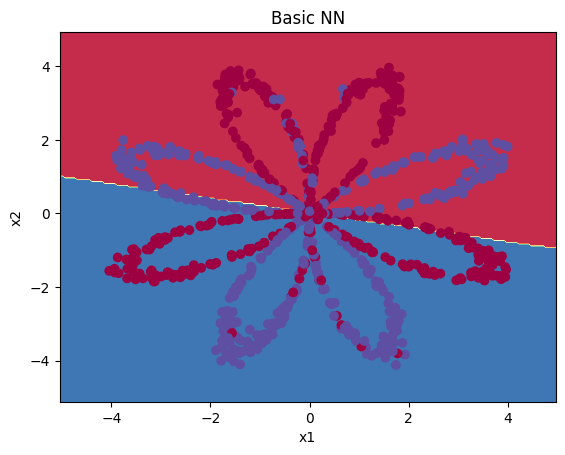

In [ ]:
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("Basic NN");

### One hidden layer NN

- One **input with 2 features (input_shape)**
- **One hidden dense layer**,  with **3 neurons** and implemented with  **sigmoid activating function**
- **One Output** (sigmoid output activation function)

We can create layers incrementally with the method `add()`:

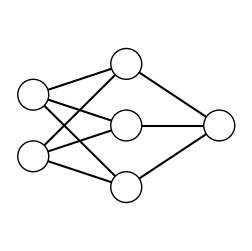

In [ ]:
draw_neural_net(.1, .9, .1, .9, [2, 3, 1])

In [ ]:
model = keras.Sequential()

## hidden layer with 3 neurons and sigmoid activation
## The first layer need to have the input_shape
model.add(layers.Dense(3, input_shape=(2,), activation='linear'))

# output layer
model.add(layers.Dense(1, activation='sigmoid'))

## model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 3)                 9         
                                                                 
 dense_2 (Dense)             (None, 1)                 4         
                                                                 
Total params: 13 (52.00 Byte)
Trainable params: 13 (52.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


You can also define the model with a list of layers
```python
model = keras.Sequential([
    keras.Input(shape=(2, )),
    layers.Dense(3, activation='sigmoid', name='layer1'),
    layers.Dense(1, activation='sigmoid', name='layer3')
])
````

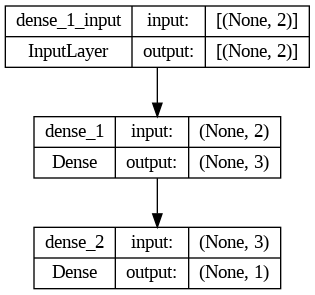

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32)

Epoch 1/25
100/100 [==============================] - 2s 6ms/step - loss: 0.6730 - accuracy: 0.4656 - val_loss: 0.6702 - val_accuracy: 0.4725
Epoch 2/25
100/100 [==============================] - 0s 4ms/step - loss: 0.6596 - accuracy: 0.4684 - val_loss: 0.6643 - val_accuracy: 0.4812
Epoch 3/25
100/100 [==============================] - 0s 4ms/step - loss: 0.6579 - accuracy: 0.4700 - val_loss: 0.6636 - val_accuracy: 0.4775
Epoch 4/25
100/100 [==============================] - 0s 3ms/step - loss: 0.6579 - accuracy: 0.4753 - val_loss: 0.6638 - val_accuracy: 0.4787
Epoch 5/25
100/100 [==============================] - 0s 3ms/step - loss: 0.6578 - accuracy: 0.4634 - val_loss: 0.6637 - val_accuracy: 0.4775
Epoch 6/25
100/100 [==============================] - 0s 3ms/step - loss: 0.6578 - accuracy: 0.4797 - val_loss: 0.6633 - val_accuracy: 0.4800
Epoch 7/25
100/100 [==============================] - 0s 3ms/step - loss: 0.6579 - accuracy: 0.4762 - val_loss: 0.6634 - val_accuracy: 0.4762
Epoch 

In [ ]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

Test Loss: 0.6640185713768005
Test Accuracy: 0.4650000035762787


1269/1269 [==============================] - 2s 1ms/step


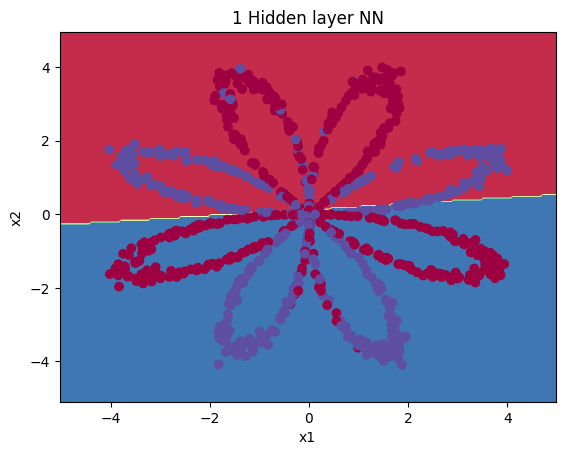

In [ ]:
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 Hidden layer NN");

### Question 1:
####  What happens if we change the activation function of the first hidden  layer to `'linear'`?

In [ ]:
model = keras.Sequential()
## The first layer need to have the input_shape
## change the activation function
model.add(layers.Dense(3, input_shape=(2,), activation='sigmoid'))
# output layer
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32)

Epoch 1/25
100/100 [==============================] - 2s 7ms/step - loss: 0.6866 - accuracy: 0.6172 - val_loss: 0.6878 - val_accuracy: 0.6575
Epoch 2/25
100/100 [==============================] - 0s 4ms/step - loss: 0.6806 - accuracy: 0.6453 - val_loss: 0.6825 - val_accuracy: 0.6687
Epoch 3/25
100/100 [==============================] - 0s 4ms/step - loss: 0.6753 - accuracy: 0.6541 - val_loss: 0.6775 - val_accuracy: 0.6725
Epoch 4/25
100/100 [==============================] - 0s 3ms/step - loss: 0.6705 - accuracy: 0.6666 - val_loss: 0.6730 - val_accuracy: 0.6737
Epoch 5/25
100/100 [==============================] - 0s 3ms/step - loss: 0.6660 - accuracy: 0.6678 - val_loss: 0.6689 - val_accuracy: 0.6775
Epoch 6/25
100/100 [==============================] - 0s 3ms/step - loss: 0.6620 - accuracy: 0.6797 - val_loss: 0.6652 - val_accuracy: 0.6812
Epoch 7/25
100/100 [==============================] - 0s 3ms/step - loss: 0.6585 - accuracy: 0.6816 - val_loss: 0.6621 - val_accuracy: 0.6812
Epoch 

Test Loss: 0.6054102182388306
Test Accuracy: 0.6340000033378601
1269/1269 [==============================] - 2s 1ms/step


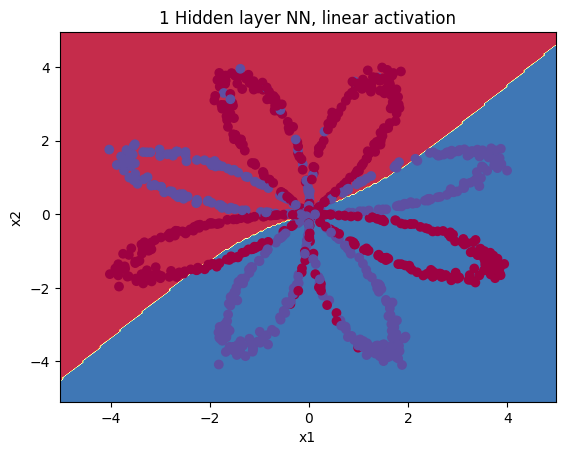

In [ ]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 Hidden layer NN, linear activation");

### Question 2:
####  What happens if we add more neurons to the first hidden layer ?

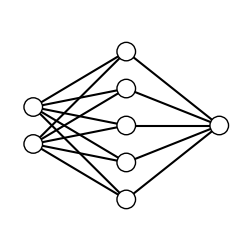

In [ ]:
draw_neural_net(.1, .9, .1, .9, [2, 5, 1])

In [ ]:
model = keras.Sequential()

## The first layer need to have the input_shape
## set the number of neurons
model.add(layers.Dense(5, input_shape=(2,), activation='sigmoid'))

# output layer
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32)

Epoch 1/25
100/100 [==============================] - 1s 5ms/step - loss: 0.6761 - accuracy: 0.5934 - val_loss: 0.6650 - val_accuracy: 0.6338
Epoch 2/25
100/100 [==============================] - 0s 3ms/step - loss: 0.6590 - accuracy: 0.6491 - val_loss: 0.6521 - val_accuracy: 0.6650
Epoch 3/25
100/100 [==============================] - 0s 3ms/step - loss: 0.6472 - accuracy: 0.6400 - val_loss: 0.6431 - val_accuracy: 0.6225
Epoch 4/25
100/100 [==============================] - 0s 3ms/step - loss: 0.6388 - accuracy: 0.6084 - val_loss: 0.6366 - val_accuracy: 0.5913
Epoch 5/25
100/100 [==============================] - 0s 3ms/step - loss: 0.6321 - accuracy: 0.5722 - val_loss: 0.6313 - val_accuracy: 0.5675
Epoch 6/25
100/100 [==============================] - 0s 3ms/step - loss: 0.6267 - accuracy: 0.5534 - val_loss: 0.6267 - val_accuracy: 0.5362
Epoch 7/25
100/100 [==============================] - 0s 3ms/step - loss: 0.6220 - accuracy: 0.5353 - val_loss: 0.6229 - val_accuracy: 0.5138
Epoch 

Test Loss: 0.5887681841850281
Test Accuracy: 0.5139999985694885
1269/1269 [==============================] - 2s 1ms/step


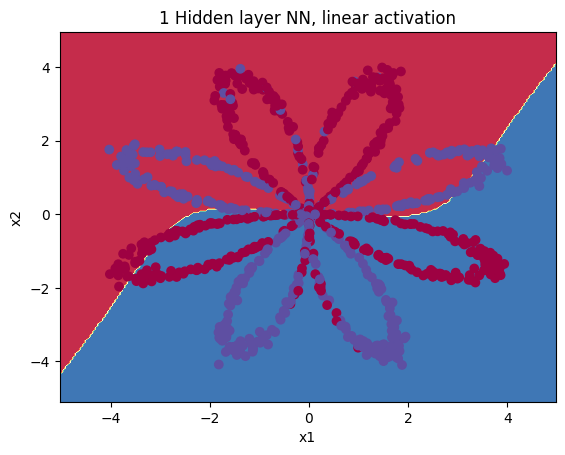

In [ ]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 Hidden layer NN, linear activation");

### Question 3:
####  What happens if we add one more hidden layer ?

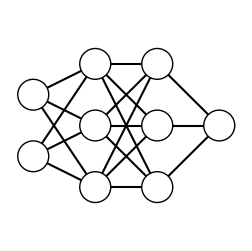

In [ ]:
draw_neural_net(.1, .9, .1, .9, [2, 3, 3, 1])

In [ ]:
model = keras.Sequential()
# First hidden layer (need to innclude input_shape)
## Set the number of neurons
model.add(layers.Dense(3, input_shape=(2,), activation='sigmoid'))

# second hidden layer
## Complete the code
model.add(layers.Dense(3, activation='sigmoid'))

# output layer
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 3)                 9         
                                                                 
 dense_13 (Dense)            (None, 3)                 12        
                                                                 
 dense_14 (Dense)            (None, 1)                 4         
                                                                 
Total params: 25 (100.00 Byte)
Trainable params: 25 (100.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32)

Epoch 1/25
100/100 [==============================] - 2s 5ms/step - loss: 0.7040 - accuracy: 0.5044 - val_loss: 0.6919 - val_accuracy: 0.5088
Epoch 2/25
100/100 [==============================] - 0s 3ms/step - loss: 0.6894 - accuracy: 0.5172 - val_loss: 0.6854 - val_accuracy: 0.5312
Epoch 3/25
100/100 [==============================] - 0s 3ms/step - loss: 0.6843 - accuracy: 0.5803 - val_loss: 0.6818 - val_accuracy: 0.6413
Epoch 4/25
100/100 [==============================] - 0s 4ms/step - loss: 0.6806 - accuracy: 0.6237 - val_loss: 0.6783 - val_accuracy: 0.6338
Epoch 5/25
100/100 [==============================] - 0s 3ms/step - loss: 0.6768 - accuracy: 0.6247 - val_loss: 0.6743 - val_accuracy: 0.6225
Epoch 6/25
100/100 [==============================] - 0s 3ms/step - loss: 0.6723 - accuracy: 0.6131 - val_loss: 0.6696 - val_accuracy: 0.6200
Epoch 7/25
100/100 [==============================] - 0s 4ms/step - loss: 0.6674 - accuracy: 0.6144 - val_loss: 0.6645 - val_accuracy: 0.6187
Epoch 

Test Loss: 0.5934035181999207
Test Accuracy: 0.6209999918937683
1269/1269 [==============================] - 2s 1ms/step


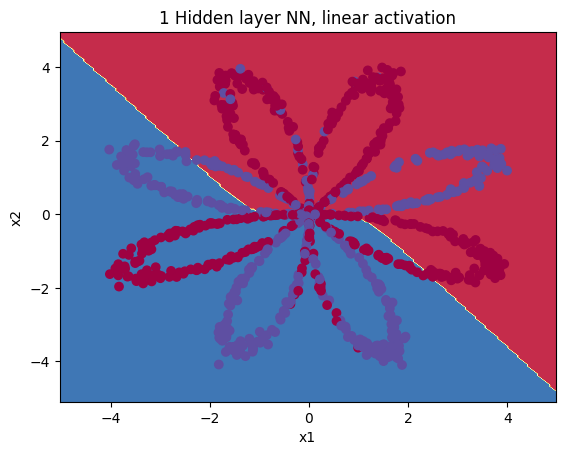

In [ ]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 Hidden layer NN, linear activation");

####  Use  the [hyperbolic tangent](https://mathworld.wolfram.com/HyperbolicTangent.html) activation `'tanh'` with the first simple model and compare the results with the sigmoid activation

In [ ]:
model = keras.Sequential()
## The first layer need to have the input_shape
## change the activation function
model.add(layers.Dense(10, input_shape=(2,), activation='tanh'))
# output layer
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32)

Epoch 1/25
100/100 [==============================] - 1s 5ms/step - loss: 0.6527 - accuracy: 0.6666 - val_loss: 0.6196 - val_accuracy: 0.6275
Epoch 2/25
100/100 [==============================] - 0s 3ms/step - loss: 0.5963 - accuracy: 0.6422 - val_loss: 0.5748 - val_accuracy: 0.7287
Epoch 3/25
100/100 [==============================] - 0s 3ms/step - loss: 0.5551 - accuracy: 0.7575 - val_loss: 0.5370 - val_accuracy: 0.7862
Epoch 4/25
100/100 [==============================] - 0s 3ms/step - loss: 0.5183 - accuracy: 0.8091 - val_loss: 0.5009 - val_accuracy: 0.8213
Epoch 5/25
100/100 [==============================] - 0s 3ms/step - loss: 0.4844 - accuracy: 0.8334 - val_loss: 0.4692 - val_accuracy: 0.8375
Epoch 6/25
100/100 [==============================] - 0s 3ms/step - loss: 0.4553 - accuracy: 0.8497 - val_loss: 0.4432 - val_accuracy: 0.8562
Epoch 7/25
100/100 [==============================] - 0s 3ms/step - loss: 0.4314 - accuracy: 0.8644 - val_loss: 0.4215 - val_accuracy: 0.8662
Epoch 

Test Loss: 0.30083388090133667
Test Accuracy: 0.8859999775886536
1269/1269 [==============================] - 2s 1ms/step


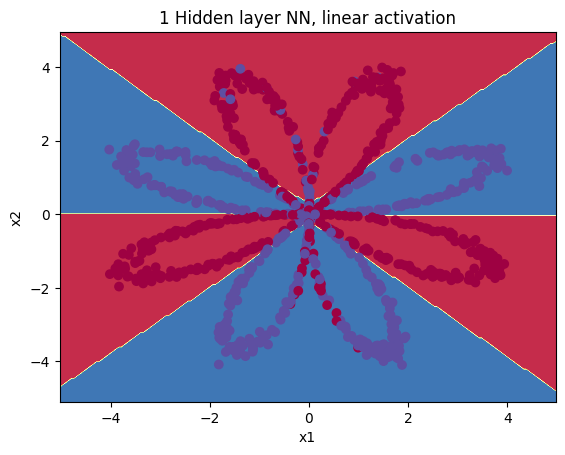

In [ ]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 Hidden layer NN, linear activation");

## Practice I

Repeat the process with a different dataset.

In [ ]:
N = 5000
X, y = sklearn.datasets.make_moons(n_samples=N, noise=.18)

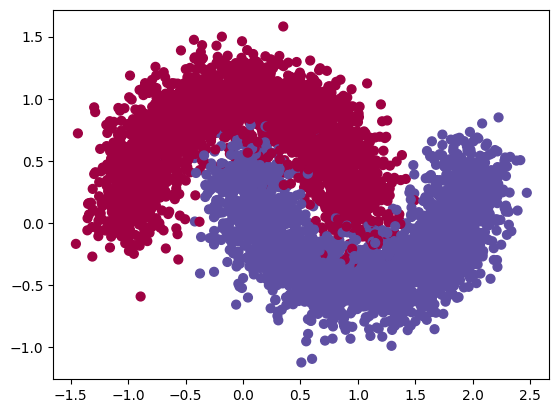

In [ ]:
# Visualize the data:
plt.scatter(X[:,0], X[:,1], c=y.ravel(), s=40, cmap=plt.cm.Spectral);

In [ ]:
# train test split
from sklearn.model_selection import train_test_split

(X_train, X_test, y_train, y_test) = train_test_split(
    X,
    y,
    test_size=0.25,
)
print('X shape:{0}, y shape:{1}'.format(X.shape, y.shape))
print('X_train shape:{0}, y_train shape:{1}'.format(X_train.shape,
                                                    y_train.shape))
print('X_test shape:{0}, y_test shape:{1}'.format(X_test.shape, y_test.shape))

X shape:(5000, 2), y shape:(5000,)
X_train shape:(3750, 2), y_train shape:(3750,)
X_test shape:(1250, 2), y_test shape:(1250,)


### Define your model

In [ ]:
model = keras.Sequential()
## The first layer need to have the input_shape
model.add(layers.Dense(16, input_shape=(2,), activation='tanh'))

## Second Layer, don't use input_shape
model.add(layers.Dense(16, activation='tanh'))

# output layer
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=35, validation_split=0.2, batch_size=64)

Epoch 1/35
47/47 [==============================] - 2s 8ms/step - loss: 0.6829 - accuracy: 0.4977 - val_loss: 0.5768 - val_accuracy: 0.6800
Epoch 2/35
47/47 [==============================] - 0s 5ms/step - loss: 0.4946 - accuracy: 0.7517 - val_loss: 0.4525 - val_accuracy: 0.7720
Epoch 3/35
47/47 [==============================] - 0s 4ms/step - loss: 0.3935 - accuracy: 0.8110 - val_loss: 0.3831 - val_accuracy: 0.8173
Epoch 4/35
47/47 [==============================] - 0s 4ms/step - loss: 0.3366 - accuracy: 0.8420 - val_loss: 0.3444 - val_accuracy: 0.8400
Epoch 5/35
47/47 [==============================] - 0s 4ms/step - loss: 0.3035 - accuracy: 0.8643 - val_loss: 0.3219 - val_accuracy: 0.8573
Epoch 6/35
47/47 [==============================] - 0s 5ms/step - loss: 0.2855 - accuracy: 0.8787 - val_loss: 0.3124 - val_accuracy: 0.8587
Epoch 7/35
47/47 [==============================] - 0s 4ms/step - loss: 0.2769 - accuracy: 0.8830 - val_loss: 0.3067 - val_accuracy: 0.8627
Epoch 8/35
47/47 [==

Test Loss: 0.10007180273532867
Test Accuracy: 0.9679999947547913
334/334 [==============================] - 1s 2ms/step


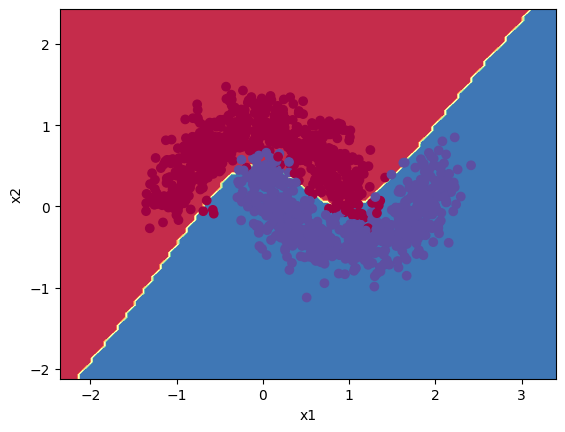

In [ ]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)

## Functional API

The Keras Functional API allows defining the topology of the models as a [acyclic directed graph](https://en.wikipedia.org/wiki/Directed_acyclic_graph) of layers. Next we will build the same model as in the previous section but using the Keras Functional API.

You need to start with an input data entry:
```python    
    inputs = keras.Input(shape=(8,))
```
    
We define the layers that we will include in the network and the relationships between them. It is important to note that each line details the type of layer and its properties (number of neurons, activation function, name ...) and just at the end, in parentheses, the name of the variable in which we have saved the layer from which its output will connect to the input of the layer we are declaring.
```python
layer_1 = layers.Dense(4, activation='sigmoid',
                       name='layer_1')(inputs)
layer_2 = layers.Dense(4, activation='sigmoid',
                       name='layer_2')(layer_1)
```

The "layer call" `Dense()(inputs)` action is like drawing an arrow from "inputs" to this layer you created. You're "passing" the inputs to the dense layer, and you get `layer_1` as the output.

  

Finally, we define the network outputs:
```python
outputs = layers.Dense(1, name='output_layer')(layer_2)
```

We create the model specifying the inputs and outputs:
```python
model = keras.Model(inputs=inputs, outputs=outputs)
```

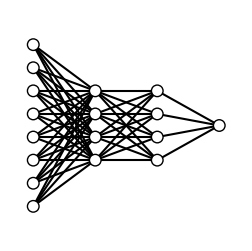

In [ ]:
draw_neural_net(.1, .9, .1, .9, [8, 4, 4, 1])

In [ ]:
inputs = keras.Input(shape=(8, ), name='input_layer')
l_1 = layers.Dense(4, activation='relu', name='layer_1')(inputs)
l_2 = layers.Dense(4, activation='relu', name='layer_2')(l_1)
outputs = layers.Dense(1, name='output_layer')(l_2)

model = keras.Model(inputs=inputs, outputs=outputs, name='example_model')

model.summary()

Model: "example_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 8)]               0         
                                                                 
 layer_1 (Dense)             (None, 4)                 36        
                                                                 
 layer_2 (Dense)             (None, 4)                 20        
                                                                 
 output_layer (Dense)        (None, 1)                 5         
                                                                 
Total params: 61 (244.00 Byte)
Trainable params: 61 (244.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


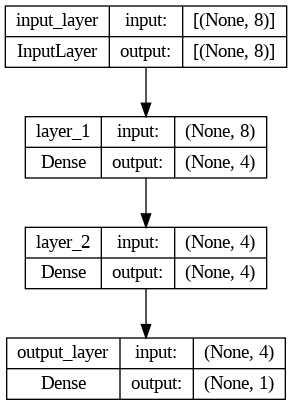

In [ ]:
plot_model(model, show_shapes=True)

## Practice II

Repeat the process with a different dataset and the **Functional API**

In [ ]:
N = 5000
X, y = sklearn.datasets.make_circles(n_samples=N, factor=.65, noise=.065) # sklearn.datasets.make_moons(n_samples=N, noise=.15)

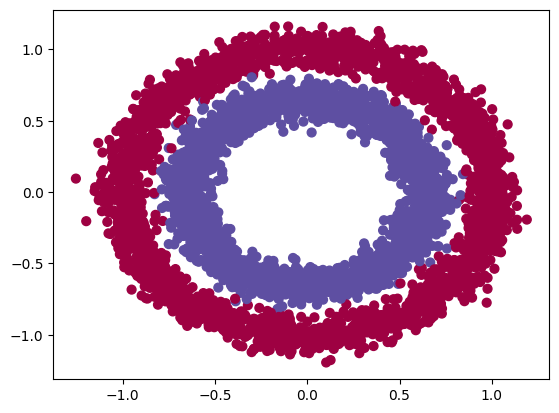

In [ ]:
# Visualize the data:
plt.scatter(X[:,0], X[:,1], c=y.ravel(), s=40, cmap=plt.cm.Spectral);

In [ ]:
# train test split
from sklearn.model_selection import train_test_split

(X_train, X_test, y_train, y_test) = train_test_split(
    X,
    y,
    test_size=0.25,
)
print('X shape:{0}, y shape:{1}'.format(X.shape, y.shape))
print('X_train shape:{0}, y_train shape:{1}'.format(X_train.shape,
                                                    y_train.shape))
print('X_test shape:{0}, y_test shape:{1}'.format(X_test.shape, y_test.shape))

X shape:(5000, 2), y shape:(5000,)
X_train shape:(3750, 2), y_train shape:(3750,)
X_test shape:(1250, 2), y_test shape:(1250,)


### Define your model

In [ ]:
inputs = keras.Input(shape=(2, ), name='input_layer')
## First hidden layer
l_1 = layers.Dense(8, activation='relu')(inputs)
l_2 = layers.Dense(8, activation='relu')(l_1)

## output layer
outputs = layers.Dense(1, activation='sigmoid')(l_2)

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=35, validation_split=0.2, batch_size=64)

Epoch 1/35
47/47 [==============================] - 2s 8ms/step - loss: 0.6900 - accuracy: 0.4913 - val_loss: 0.6852 - val_accuracy: 0.4867
Epoch 2/35
47/47 [==============================] - 0s 4ms/step - loss: 0.6779 - accuracy: 0.5217 - val_loss: 0.6760 - val_accuracy: 0.4893
Epoch 3/35
47/47 [==============================] - 0s 5ms/step - loss: 0.6665 - accuracy: 0.5427 - val_loss: 0.6650 - val_accuracy: 0.5333
Epoch 4/35
47/47 [==============================] - 0s 4ms/step - loss: 0.6533 - accuracy: 0.5937 - val_loss: 0.6517 - val_accuracy: 0.5987
Epoch 5/35
47/47 [==============================] - 0s 5ms/step - loss: 0.6370 - accuracy: 0.6353 - val_loss: 0.6343 - val_accuracy: 0.6333
Epoch 6/35
47/47 [==============================] - 0s 7ms/step - loss: 0.6162 - accuracy: 0.6960 - val_loss: 0.6141 - val_accuracy: 0.7160
Epoch 7/35
47/47 [==============================] - 0s 7ms/step - loss: 0.5921 - accuracy: 0.7607 - val_loss: 0.5892 - val_accuracy: 0.7453
Epoch 8/35
47/47 [==

Test Loss: 0.05882768705487251
Test Accuracy: 0.995199978351593
237/237 [==============================] - 0s 2ms/step


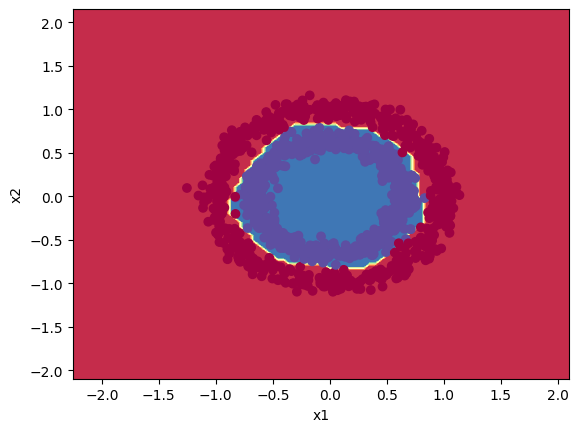

In [ ]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)

## Visualize decision boundary by epoch

In [ ]:
from sklearn.preprocessing import StandardScaler
from IPython.display import Image
import os

In [ ]:
def plot_save_decision_boundary(model, X, y, epoch, epoch_image):
    h = 0.1
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    X_grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(X_grid)
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.5, colors=['blue', 'red'], levels=[-0.5, 0.5, 1.5])
    plt.scatter(X[y[:, 0] == 0][:, 0], X[y[:, 0] == 0][:, 1], color='blue', label='Class 0', alpha=0.5)
    plt.scatter(X[y[:, 0] == 1][:, 0], X[y[:, 0] == 1][:, 1], color='red', label='Class 1', alpha=0.5)
    plt.title(f'Epoch {epoch}')
    plt.savefig(epoch_image)
    plt.close()

def generate_spiral_dataset(n_points, noise=0.5):
    n = np.sqrt(np.random.rand(n_points, 1)) * 780 * (2 * np.pi) / 360
    d1x = -np.cos(n) * n + np.random.rand(n_points, 1) * noise
    d1y = np.sin(n) * n + np.random.rand(n_points, 1) * noise

    X, y = (np.vstack((np.hstack((d1x, d1y)), np.hstack((-d1x, -d1y)))),
            np.hstack((np.zeros(n_points), np.ones(n_points))))
    return X, y.reshape(-1, 1)

n_points = 2500
X, y = generate_spiral_dataset(n_points)

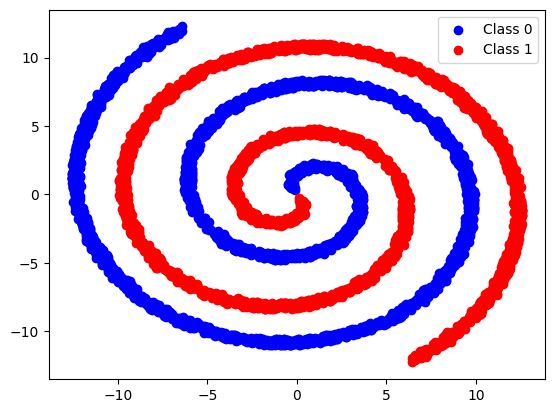

In [ ]:
plt.scatter(X[y[:, 0] == 0][:, 0], X[y[:, 0] == 0][:, 1], color='blue', label='Class 0')
plt.scatter(X[y[:, 0] == 1][:, 0], X[y[:, 0] == 1][:, 1], color='red', label='Class 1')
plt.legend()
plt.show()

In [ ]:
# Normalize data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Create the first model
model1 = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_shape=(2,)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Create the second model
model2 = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_shape=(2,)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Create the third model
model3 = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_shape=(2,)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Store the models in a list
model_list = [model1, model2, model3]

# Lets do some experimentation with different learning rates
model_list[0].compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_list[1].compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_list[2].compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
              loss='binary_crossentropy',
              metrics=['accuracy'])

n_epochs = 60
epoch_images = {0: [], 1: [], 2: []}

for epoch in range(n_epochs):
    for ix in range(len(model_list)):
      model_list[ix].fit(X_train, y_train, epochs=1, verbose=0)
      epoch_image = f'epoch_{epoch}_model_{ix}.png'
      epoch_images[ix].append(epoch_image)

      plot_save_decision_boundary(model_list[ix], X_test, y_test, epoch, epoch_image)

102/102 [==============================] - 0s 2ms/step


In [ ]:
from PIL import Image as Image_PIL

# Create the GIF

for ix in range(len(model_list)):
  gif_filename = f'epoch_animation_model_{ix}.gif'
  images = [Image_PIL.open(epoch_image) for epoch_image in epoch_images[ix]]

  duration = 0.15
  images[0].save(gif_filename,
              format='GIF',
              append_images=images[1:],
              save_all=True,
              duration=duration*1000,
              loop=0)

  # Delete the individual epoch images
  for epoch_image in epoch_images[ix]:
      os.remove(epoch_image)

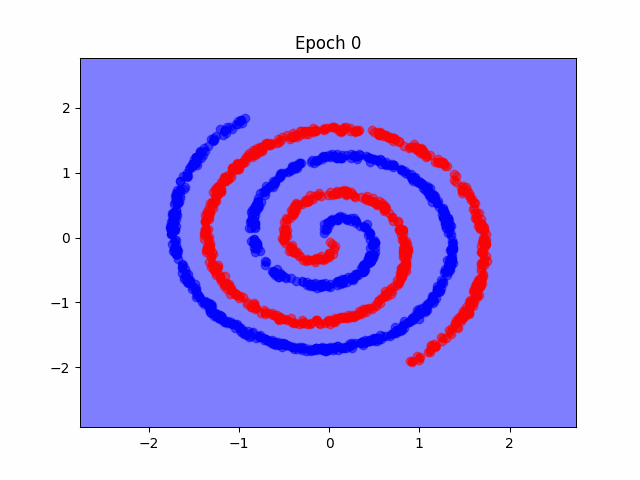

In [ ]:
# Model with LR=0.0001
Image(filename='epoch_animation_model_0.gif')

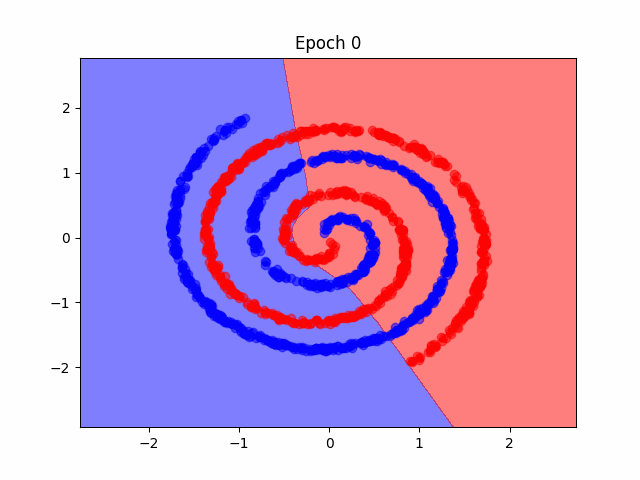

In [ ]:
# Model with LR=0.01
Image(filename='epoch_animation_model_1.gif')

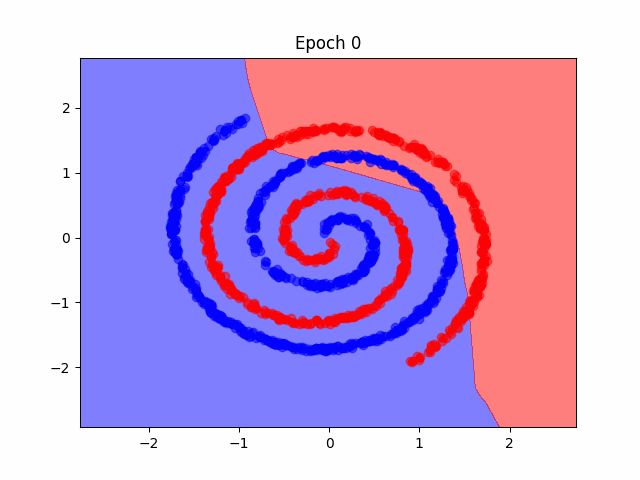

In [ ]:
# Model with LR=0.1
Image(filename='epoch_animation_model_2.gif')